In [ ]:
# Creating a route planner for a road network

In [3]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd


In [1]:
##################################################
# function: dirichletSampler
# Creates transition matrix with sampling uncertainty
# input: matrix of raw transition counts
# output: matrix of transition probabilities sampled from a Dirichlet for each column
# note: add 1 to each matrix element for proper interpretation
# of rdirichlet paramaters as param = number of successes + 1
#------------------------------------------------- 
import tensorflow
import tensorflow_probability as tfp
tfd = tfp.distributions
tfd
# x = np.random.poisson(lam=5, size=(4,4))
# dd = np.random.default_rng().dirichlet(x).transpose()
# # # def dirichletSampler():
# d = np.random.dirichlet((10, 6, 3), 10).transpose()

# s = np.random.default_rng().dirichlet((10, 5, 3), 5).transpose()
# s


<module 'tensorflow_probability.python.distributions' from 'C:\\Program Files\\Python37\\lib\\site-packages\\tensorflow_probability\\python\\distributions\\__init__.py'>

In [2]:
from container_packing.shortcuts import pack_products_into_restrictions

help(pack_products_into_restrictions)
boxes = [{
  'x': 12,
  'y': 13,
  'z': 30,
  'quantity': 2
}, {
  'x': 12,
  'y': 23,
  'z': 40,
  'quantity': 4
}]

conataner_max_sizes = (60, 60, 90)

container_x, container_y, container_z = pack_products_into_restrictions(
    boxes,
    conataner_max_sizes
)


Help on function pack_products_into_restrictions in module container_packing.shortcuts:

pack_products_into_restrictions(products: List[Union[tuple, dict]], restrictions: tuple) -> Union[tuple, NoneType]
    Pack product into container with given restrictions.
    
    :param products: list with tuples of width, depth and height of product
         or with dicts with with (key x), depth (y), height (z) and quantity,
    :param restrictions: tuple with width, depth and height of container,
    :return: tuple with minimal width, depth and height of container
        that can hold all products or None if there is no container with
        given restrictions.



In [16]:
"""Vehicles Routing Problem (VRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()


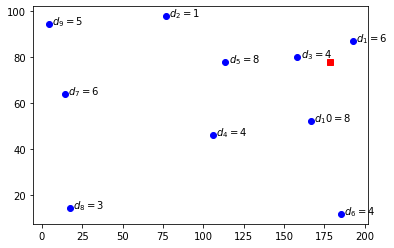

In [2]:
#Importing the package numpy as np.
import numpy as np
#Importing the package matplotlib.pyplot as plt.
import matplotlib.pyplot as plt
# "rnd" is an object that generate random numbers.
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers.
rnd.seed(0)
# Number of customers.
n = 10
# Maximum capacity of the vehicle.
Q = 20
#The set of nodes without the depot.
N = [i for i in range(1,n+1)]
# The set of nodes + the depot.
V = [0]+ N
# A collection that contains the demand of each node.
d = {i: rnd.randint(1, 10) for i in N}
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n+1)*100
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$d_%d=%d$'%(i,q[i]),(xc[i]+2,yc[i]))
#Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
#Showing the Initial plot.
plt.show()
#Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
#Calculating the distance between each node.
c= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}


In [1]:
#Importing the docplex.mp.model from the CPLEX as Model
from docplex.mp.model import Model
mdl = Model('CVRP')
#Initializing our binary variable x_i,j
x=mdl.binary_var_dict (A,name='x')
#Initializing our cumulative demand u
u=mdl.continuous_var_dict (N,ub=Q ,name = 'u')
#Initializing the objectif function
mdl.minimize(mdl.sum(c[i,j]*x[i,j]for i,j in A))
#Initialzing the first constraint
mdl.add_constraints(mdl.sum(x[i,j]for j in V if j!=i)==1 for i in N)
#Initialzing the second constraint
mdl.add_constraints(mdl.sum(x[i,j]for i in V if i!=j)==1 for j in N)
#Initialzing the third constraint
mdl.add_indicator_constraints_(mdl.indicator_constraint(x[i,j],u[i]+d[j]==u[j])for i,j in A if i!=0 and j!=0)
#Initialzing the fourth constraint
mdl.add_constraints(u[i]>=d[i] for i in N)
#Getting the solution
solution =mdl.solve(log_output=True)
#Printing the solution
print(solution)
#Identifing the active arcs.
active_arcs =[  a for a in A if x[a].solution_value> 0.9]
plt.scatter(loc_x[1:],loc_y[1:],c='b')
for i in N:
    plt.annotate('$d_%d=%d$'%(i,d[i]),(loc_x[i]+2,loc_y[i]))
for i,j in active_arcs :
#Coloring the active arcs
    plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='g',alpha=0.3)
    plt.plot(loc_x[0],loc_y[0],c='r' ,marker='s')
#Plotting the solution
plt.show()

NameError: name 'A' is not defined

In [2]:
# from mip import cbc 
#Importing the docplex.mp.model from the CPLEX as Model
import pulp as plp
mdl = plp.LpProblem(name="CVRP")
#Initializing our binary variable x_i,j
x=plp.LpVariable.dicts('x', A, cat='Binary')
# x_vars  = {(i,j):plp.LpVariable(cat=plp.LpBinary, name="x_{0}_{1}".format(i,j)) for i in set_I for j in set_J}
#Initializing our cumulative demand u
u=plp.LpVariable('u',N, upBound = Q, cat='Continuous')

#Initialzing the first constraint

mdl.addConstraint(plp.LpConstraint(
             e=plp.lpSum((x[i,j]for j in V if j!=i) for i in N),
             sense=plp.LpConstraintEQ,
             rhs=1 
             ))
#Initialzing the second constraint
mdl.addConstraint(plp.LpConstraint(
             e=plp.lpSum((x[i,j]for i in V if i!=j) for j in N),
             sense=plp.LpConstraintEQ,
             rhs=1))
#Initialzing the third constraint
# mdl.add_indicator_constraints_(mdl.indicator_constraint(x[i,j],u[i]+d[j]==u[j])for i,j in A if i!=0 and j!=0)
#Initialzing the fourth constraint

# mdl.addConstraint(plp.LpConstraint(e=(u[i]for i in N) ,sense=plp.LpConstraintGE,rhs=d[i]))

#Initializing the objectif function

objective = plp.lpSum(c[i,j]*x[i,j]for i,j in A)
mdl.sense = plp.LpMinimize
mdl.setObjective(objective)

#Getting the solution
solution =mdl.solve()
#Printing the solution
print(solution)
#Identifing the active arcs.
# active_arcs =[  a for a in A if x[a].solution_value> 0.9]
# plt.scatter(loc_x[1:],loc_y[1:],c='b')
# for i in N:
#     plt.annotate('$d_%d=%d$'%(i,d[i]),(loc_x[i]+2,loc_y[i]))
# for i,j in active_arcs :
# #Coloring the active arcs
#     plt.plot([loc_x[i],loc_x[j]],[loc_y[i],loc_y[j]],c='g',alpha=0.3)
#     plt.plot(loc_x[0],loc_y[0],c='r' ,marker='s')
# #Plotting the solution
# plt.show()

ModuleNotFoundError: No module named 'mip'

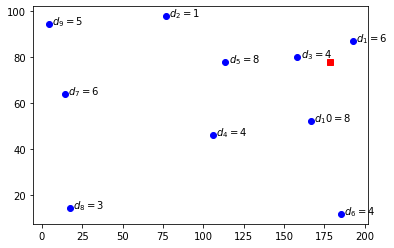

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# "rnd" is an object that generate random numbers.
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers.
rnd.seed(0)
# Number of customers.
n = 10
# Maximum capacity of the vehicle.
Q = 20
#The set of nodes without the depot.
N = [i for i in range(1,n+1)]
# The set of nodes + the depot.
V = [0]+ N
# A collection that contains the demand of each node.
q = {i: rnd.randint(1, 10) for i in N}
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n+1)*100
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$d_%d=%d$'%(i,q[i]),(xc[i]+2,yc[i]))
#Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
#Showing the Initial plot.
plt.show()
#Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
#Calculating the distance between each node.
dist= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
#generate historical data for eac route
hist = {(i, j): rnd.randint(1, 10) for i, j in A}


In [280]:
from scipy.stats import multinomial
from scipy.stats import dirichlet
rv = multinomial(10, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

rv.rvs(10)
# multinomial.rvs(n, 0.29, size=1)
# quantiles = np.array([1, 2, 3])  # specify quantiles
# alpha = np.array([10, 10, 1])  # specify concentration parameters
# # numpy.random.choice(['a','b','c'], size = 20, p = [0.3,0.4,0.3])
# rv2 = dirichlet(alpha)
# dir(rv2)
# rv2.rvs(size=1)
# rv.rvs(10)

array([[2, 3, 1, 0, 0, 1, 0, 0, 2, 0],
       [3, 1, 0, 2, 0, 0, 1, 1, 1, 0],
       [1, 2, 0, 1, 2, 1, 0, 2, 0, 0],
       [3, 1, 1, 1, 0, 0, 2, 0, 1, 0],
       [3, 0, 0, 1, 1, 0, 3, 1, 0, 0],
       [1, 0, 1, 1, 0, 1, 3, 1, 1, 0],
       [2, 0, 0, 2, 1, 2, 1, 1, 0, 0],
       [1, 2, 2, 0, 0, 0, 2, 1, 1, 0],
       [2, 2, 2, 0, 1, 0, 0, 1, 1, 0],
       [3, 0, 1, 1, 0, 2, 0, 0, 2, 0]])